In [55]:
from helpers import *
from game import *
from agents import *
from training import *
import torch
import random
from tqdm import tqdm

#### Set a Catan environment

In [56]:
config = GameConfig(
    num_players=2, 
    max_turns=200, 
    victory_points_to_win=10,
    allow_trading=False,
    allow_bank_trading=True,
    verbose=0
)

No players passed, defaulting to RandomAgent for all players.


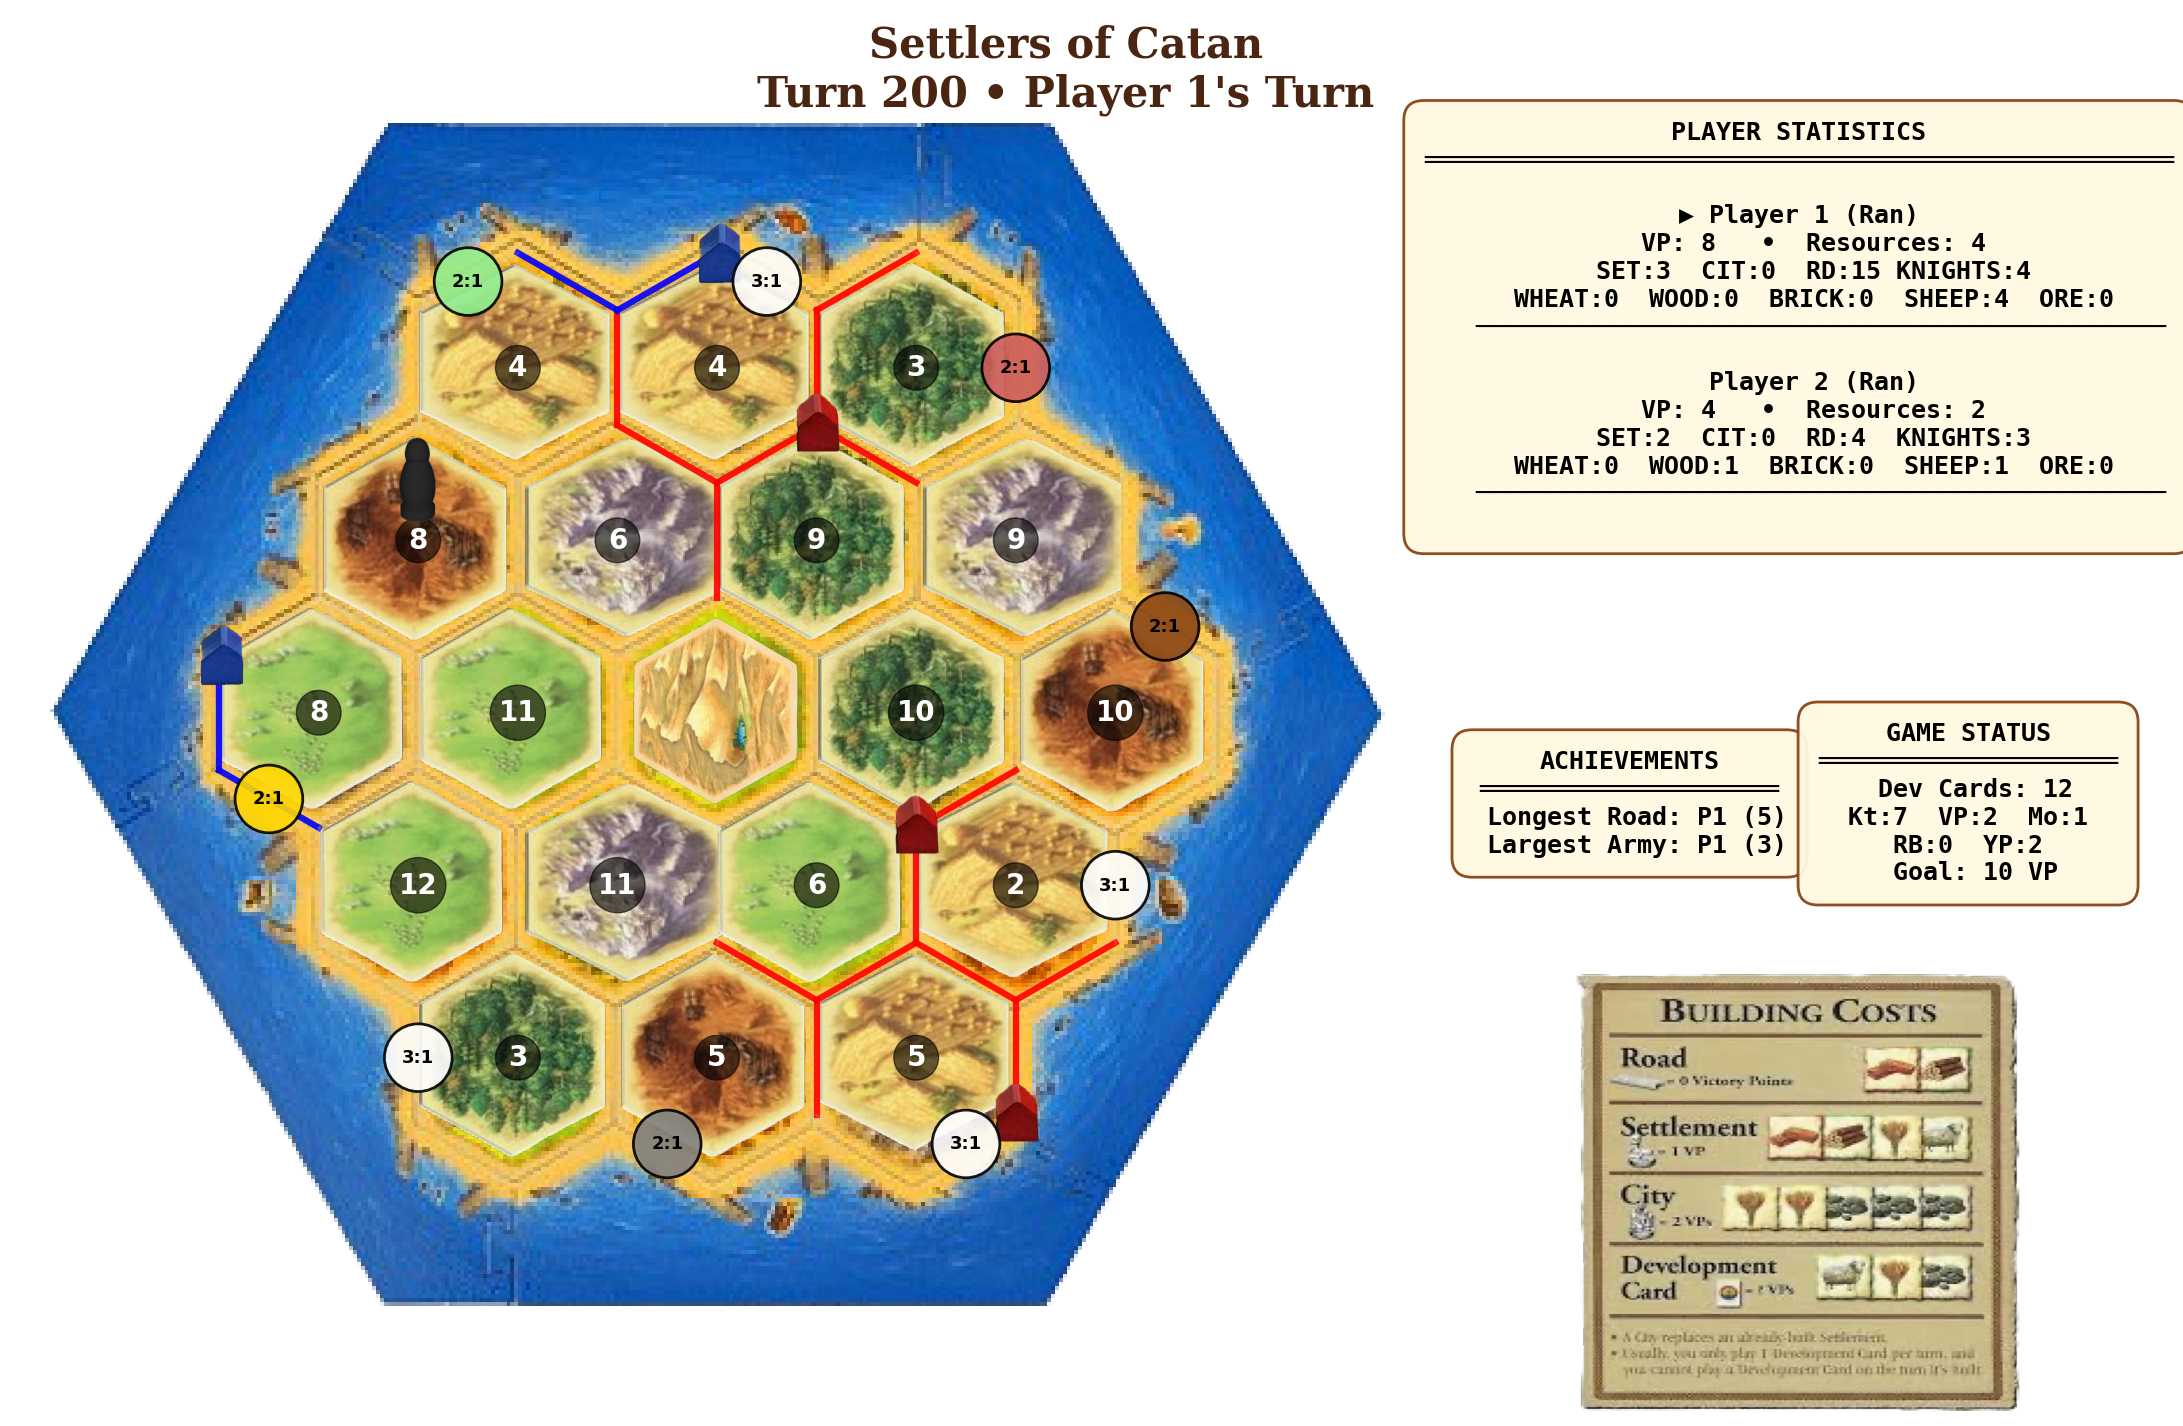

In [57]:
game = CatanGame(config=config)#, players=[])

game.play_game()
s = game.plot_state()

#### Model configs

In [59]:
SMALL_CONFIG = {
    "hidden_dim": 40,
    "num_gnn_layers": 1,
    "num_attention_heads": 2,
    "dropout": 0.1,
    "resource_emb_dim": 4,
    "roll_emb_dim": 4,
    "owner_emb_dim": 4,
    "port_emb_dim": 4,
    "player_mlp_hidden": 80,
    "global_mlp_hidden": 20,
    "trunk_hidden": 112,
    "policy_hidden_1": 56,
    "policy_hidden_2": 28,
    "value_hidden": 56,
    "value_scale": 10.0,
    "init_policy_gain": 0.01,
    "init_value_gain": 1.0,
}

MEDIUM_LITE_CONFIG = {
    "hidden_dim": 80,
    "num_gnn_layers": 2,
    "num_attention_heads": 4,
    "dropout": 0.1,
    "resource_emb_dim": 8,
    "roll_emb_dim": 6,
    "owner_emb_dim": 6,
    "port_emb_dim": 6,
    "player_mlp_hidden": 100,
    "global_mlp_hidden": 40,
    "trunk_hidden": 160,
    "policy_hidden_1": 80,
    "policy_hidden_2": 40,
    "value_hidden": 80,
    "value_scale": 10.0,
    "init_policy_gain": 0.01,
    "init_value_gain": 1.0,
}

MEDIUM_CONFIG = {
    "hidden_dim": 128,
    "num_gnn_layers": 3,
    "num_attention_heads": 8,
    "dropout": 0.1,
    "resource_emb_dim": 8,
    "roll_emb_dim": 8,
    "owner_emb_dim": 8,
    "port_emb_dim": 8,
    "player_mlp_hidden": 160,
    "global_mlp_hidden": 64,
    "trunk_hidden": 256,
    "policy_hidden_1": 128,
    "policy_hidden_2": 64,
    "value_hidden": 128,
    "value_scale": 10.0,
    "init_policy_gain": 0.01,
    "init_value_gain": 1.0,
}

LARGE_CONFIG = {
    "hidden_dim": 192,
    "num_gnn_layers": 4,
    "num_attention_heads": 6,
    "dropout": 0.15,
    "resource_emb_dim": 12,
    "roll_emb_dim": 8,
    "owner_emb_dim": 8,
    "port_emb_dim": 8,
    "player_mlp_hidden": 240,
    "global_mlp_hidden": 96,
    "trunk_hidden": 320,
    "policy_hidden_1": 160,
    "policy_hidden_2": 80,
    "value_hidden": 160,
    "value_scale": 10.0,
    "init_policy_gain": 0.01,
    "init_value_gain": 1.0,
}

for size, cfg in [('small', SMALL_CONFIG), ('medium_lite', MEDIUM_LITE_CONFIG), ('medium', MEDIUM_CONFIG), ('large', LARGE_CONFIG)]:
    network = CatanGNNTransformerNetwork(config, **cfg)
    num_params = network.get_num_parameters()
    suffixes = ['', 'k', 'M', 'B', 'T']
    while num_params >= 1000:
        num_params /= 1000.0
        suffixes.pop(0)
    print(f"{size.capitalize()} network has {num_params:.2f}{suffixes[0]} parameters.")

Small network has 193.14k parameters.
Medium_lite network has 434.77k parameters.
Medium network has 1.12M parameters.
Large network has 2.04M parameters.


### Collect game data for imitation learning

In [ ]:
#for num_games in [50, 100, 500, 1000, 10000, 20000]:
encoder = StateEncoder(config)
collector = SupervisedDataCollector(encoder)
num_games = 50
print(f"Collecting {num_games} games...")
for game_num in tqdm(range(num_games)):
    episode_data = collector.collect_from_game(None, player_id=0)
    expert = AgentLogging(0, 'red', collector, episode_data)
    players = [expert] + [GreedyAgent(i, player_colors[i]) for i in range(1, config.num_players)]
    
    game = CatanGame(config=config, players=players)
    game.setup_initial_placements()

    while not game.is_game_over():
        roll = game.roll_dice(game.current_player)
        game.players[game.current_player].turn(game)
        game.current_player = (game.current_player + 1) % config.num_players
        if game.current_player == 0:
            game.turn += 1
    
    collector.finalize_episode(episode_data, game, player_id=0)

print(f" Collected {len(collector.demonstrations)} games")
collector.save(f'supervised_data/{config.to_string()}/{num_games}games.pkl.gz')
plotted = collector.plot_metrics()

Loading compressed format...
✓ Loaded 10000 demonstrations
Loaded 10000 games
Contains 1421583 decisions


/Users/zacharywest/Downloads/RLCatan/training.py:3007: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()



DATASET SUMMARY
Total Episodes: 10000
Total Decisions: 1421583
Average Decisions per Episode: 142.2

Win Rate: 46.7%
Average Score: 7.87

Decision Type Breakdown:
  action              : 545761 ( 38.4%)
  city                : 11650 (  0.8%)
  exchange_give       : 230964 ( 16.2%)
  exchange_receive    : 230964 ( 16.2%)
  road                : 218611 ( 15.4%)
  settlement          : 39951 (  2.8%)
  tile                : 143682 ( 10.1%)

Diversity Metrics:
  Unique Settlement Locations: 54/54
  Unique Road Locations: 72/72


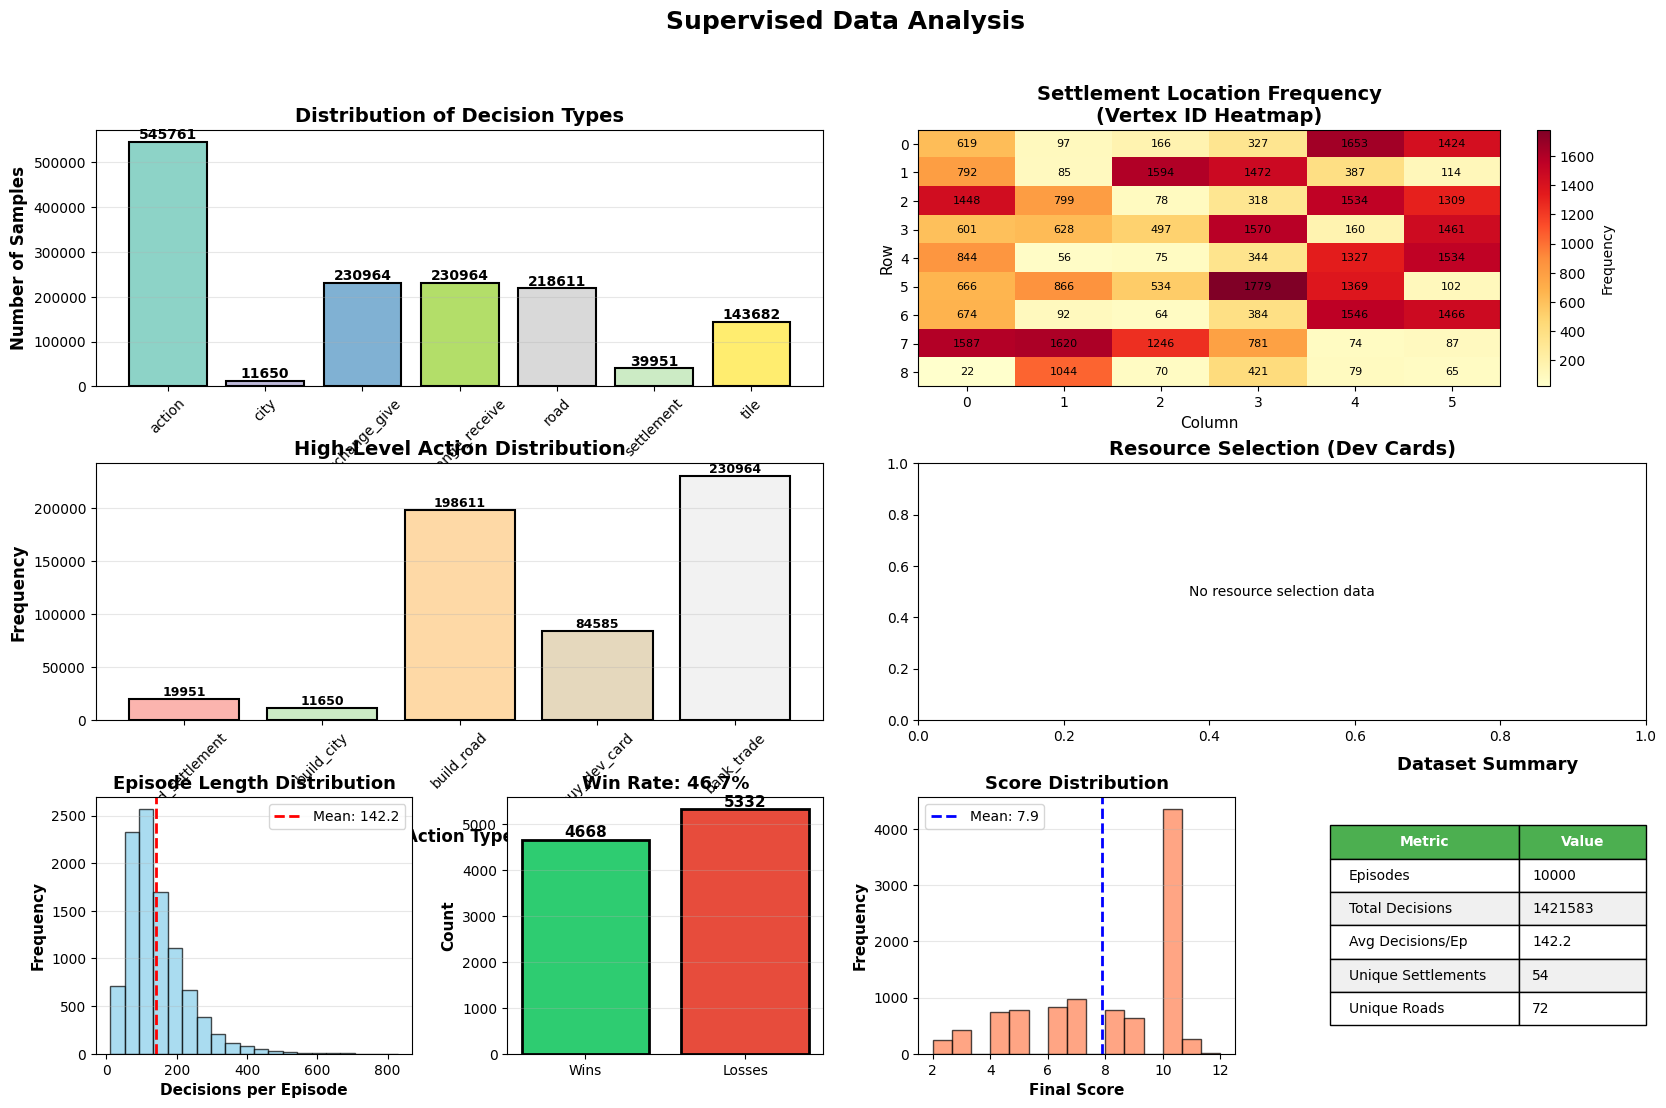

In [60]:
encoder = StateEncoder(config)
collector = SupervisedDataCollector(encoder)

collector.load(f'supervised_data/{config.to_string()}/10000games.pkl.gz') # or .pt

print(f"Loaded {len(collector.demonstrations)} games")
print(f"Contains {sum(len(episode['states']) for episode in collector.demonstrations)} decisions")
plotted = collector.plot_metrics()

#### Training on collected games

In [ ]:
net_size = SMALL_CONFIG
network = CatanGNNTransformerNetwork(config, **net_size)
trainer = ImitationLearningTrainer(network, lr=1e-4)

total_params = network.get_num_parameters()
print(f"\n{'='*70}")
print(f"TOTAL PARAMETERS: {total_params:,}")
print(f"{'='*70}\n")
print("Parameter breakdown by module:")
breakdown = network.get_parameter_breakdown()
for module, count in sorted(breakdown.items(), key=lambda x: x[1], reverse=True):
    pct = 100 * count / total_params
    print(f"  {module:30s}: {count:>10,} ({pct:5.1f}%)")

EPOCHS = 100
BATCH_SIZE = 512
LR = 1e-4
VAL_SPLIT = 0.1
NUM_DEMONSTRATIONS = len(collector.demonstrations)
TEACHER_TYPE = "GreedyAgent"

metrics = trainer.train(
    collector.demonstrations,
    num_epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    balance_heads=True,
    val_split=VAL_SPLIT,
)

model_config = {
    'hidden_dim': net_size.get('hidden_dim', 64),
    'num_gnn_layers': net_size.get('num_gnn_layers', 2),
    'num_attention_heads': net_size.get('num_attention_heads', 4),
    'dropout': net_size.get('dropout', 0.1),
    'trunk_hidden': net_size.get('trunk_hidden', 256),
}

training_config = {
    'lr': LR,
    'batch_size': BATCH_SIZE,
    'num_epochs': EPOCHS,
    'val_split': VAL_SPLIT,
    'balance_heads': True,
}

plot_imitation_training_metrics(
    metrics=metrics,
    model_config=model_config,
    training_config=training_config,
    total_params=total_params,
    num_demonstrations=NUM_DEMONSTRATIONS,
    teacher_agent_type=TEACHER_TYPE,
    save_path=f'RLmodels/imitation_models/{config.to_string()}/small_vs_{TEACHER_TYPE}_{NUM_DEMONSTRATIONS}games_{EPOCHS}epochs.png',
    show=True
)

checkpoint_path = f'RLmodels/imitation_models/{config.to_string()}/small_vs_{TEACHER_TYPE}_{NUM_DEMONSTRATIONS}games_{EPOCHS}epochs.pt'
torch.save({
    'network_state_dict': network.state_dict(),
    'config': config,
    'metrics': metrics,
    'model_config': model_config,
    'training_config': training_config,
    'total_params': total_params,
    'teacher_type': TEACHER_TYPE,
    'num_demonstrations': NUM_DEMONSTRATIONS,
}, checkpoint_path)

print(f"\n💾 Saved checkpoint to: {checkpoint_path}")
print(f"💾 Saved training visualizations")

network.eval()
for param in network.parameters():
    param.requires_grad = False
network.to(torch.device('cpu')) 

agent1 = CatanRLAgent(
    id=0, 
    color='red', 
    config=config,
    network=network
)

print("\n" + "="*60)
print("EVALUATING TRAINED NETWORK")
print("="*60)

evaluate_agent(network, RandomAgent, config, num_games=100)
evaluate_agent(network, GreedyAgent, config, num_games=100)

In [ ]:
#network = CatanGNNTransformerNetwork(config, **SMALL_CONFIG)
agent = CatanRLAgent(0, 'red', config=config, network=network)
weight_dist = plot_action_head_weights_distribution(network)
game = CatanGame(config=config, players=[agent, GreedyAgent(1, 'blue')])
game.setup_initial_placements()
fig = plot_training_diagnostics(network, collector, config, agent, game)
plt.show()

### Load a network

In [ ]:
network = CatanGNNTransformerNetwork(config, **LARGE_CONFIG)
model = torch.load('RLmodels/imitation_models/large_network_against_GreedyAgent_11000games_20epochs.pt', map_location='mps', weights_only=False)
network.load_state_dict(model['network_state_dict'])

In [ ]:
evaluate_agent(network, RandomAgent, config, num_games=20)
evaluate_agent(network, GreedyAgent, config, num_games=20)

### Reward configurations

In [ ]:
reward_config_stage1 = RewardConfig(
    vp_gain=10.0,
    vp_loss=0.0,
    
    settlement_built=2.5,
    city_built=3.0,
    road_built=0.5,

    win_reward=75.0,
    loss_reward=-20.0,

    longest_road_gained=3.0,
    longest_road_lost=0.0,
    largest_army_gained=3.0,
    largest_army_lost=0.0,

    dev_card_bought=0.5,
    knight_played=1.0,
    vp_card_revealed=0.0,

    resource_gained=0.0,
    resource_lost=0.0,
    resource_diversity_bonus=0.1,
    resource_hoarding_penalty=0.0,

    efficient_trade=0.5,
    port_usage=0.0,
    bank_trade_4to1=0.0,

    high_value_settlement=1.5,
    diverse_settlement=0.5,
    port_access_gained=1.0,
    
    robber_block_opponent=0.5,
    robber_steal_success=0.0,
    
    rank_1st=0.0,
    rank_2nd=0.0,
    rank_3rd=0.0,
    rank_4th=0.0,

    vp_lead_bonus=0.3,
    vp_behind_penalty=0.0,

    step_penalty=0.0,
    turn_penalty=0.0,
    
    second_place_reward=0.0,
    exploration_bonus=0.0,
    invalid_action_penalty=-0.05,

    normalize_rewards=False,
    reward_clip_min=None,
    reward_clip_max=None,
    
    scale_early_game=0.0,
    scale_mid_game=0.0,
    scale_late_game=0.0,
)

reward_config_stage2 = RewardConfig(
    vp_gain=15.0,
    vp_loss=0.0,

    settlement_built=2.0,
    city_built=4.0,
    road_built=0.3,

    win_reward=150.0,
    loss_reward=-15.0,
    
    longest_road_gained=8.0,
    longest_road_lost=-2.0,
    largest_army_gained=8.0,
    largest_army_lost=-2.0,

    dev_card_bought=1.0,
    knight_played=2.0,
    vp_card_revealed=0.0,
    
    resource_gained=0.0,
    resource_lost=0.0,
    resource_diversity_bonus=1.0,
    resource_hoarding_penalty=0.0,
    
    efficient_trade=0.0,
    port_usage=0.0,
    bank_trade_4to1=0.0,
    
    high_value_settlement=3.0,
    diverse_settlement=2.0,
    port_access_gained=2.0,
    
    robber_block_opponent=2.0,
    robber_steal_success=0.5,
    
    rank_1st=0.0,
    rank_2nd=0.0,
    rank_3rd=0.0,
    rank_4th=0.0,
    
    vp_lead_bonus=0.5,
    vp_behind_penalty=0.0,
    
    step_penalty=0.0,
    turn_penalty=0.0,
    second_place_reward=0.0,
    exploration_bonus=0.0,
    invalid_action_penalty=-0.5,
    
    normalize_rewards=False,
    reward_clip_min=None,
    reward_clip_max=None,
    
    scale_early_game=0.0,
    scale_mid_game=0.0,
    scale_late_game=0.0,
)

### PPO loops

In [ ]:
torch.manual_seed(42)
random.seed(42)
np.random.seed(42)

# Load imitation network
#network = CatanGNNTransformerNetwork(config, **SMALL_CONFIG)
"""model = torch.load(
    'RLmodels/ppo_models/imitation_models/trained_against_Random_500games_50epochs.pt',
    map_location='mps',
    weights_only=False
)
network.load_state_dict(model['network_state_dict'])"""

game_class_string = config.to_string()

STAGE1_EPOCHS = 2
NUM_ITERS = 5
trainer_stage1 = PPOTrainer(
    network=network,
    lr=3e-4,
    gamma=0.995,
    eps_clip=0.2,
    value_coef=1,
    entropy_coef=.02,
    reward_config=reward_config_stage1,
    window_size=50
)

checkpoint1_network = trainer_stage1.train(
    config=config,
    agent_class=CatanRLAgent,
    other_player_class=GreedyAgent,
    num_iterations=NUM_ITERS,
    episodes_per_iter=4,
    num_update_epochs=STAGE1_EPOCHS,
    batch_size=256,
    save_dir=f'RLmodels/ppo_models/anti_greedy_small/{config.to_string()}/stage1',
)

trainer_stage1.plot_training_progress(
    save_dir=f'RLmodels/ppo_models/anti_greedy_small/{game_class_string}/stage1',
    iteration=200,
    final=True
)

wr_stage1 = trainer_stage1.iteration_metrics['win_rate'][-1]
print(f" Stage 1: {wr_stage1*100:.1f}% win rate vs GreedyAgent\n")

"""trainer_stage2 = PPOTrainer(
    network=checkpoint1_network,
    lr=3e-5,
    gamma=0.99,
    eps_clip=0.1,
    value_coef=0.5,
    entropy_coef=0.01,
    reward_config=reward_config_stage2,
    window_size=50
)

final_network = trainer_stage2.train(
    config=config,
    agent_class=CatanRLAgent,
    other_player_class=CatanRLAgent,
    num_iterations=75,
    episodes_per_iter=12,
    num_update_epochs=4,
    batch_size=128,
    save_dir=f'RLmodels/ppo_models/anti_greedy_MedLite/{game_class_string}/stage2',
)

trainer_stage2.plot_training_progress(
    save_dir=f'RLmodels/ppo_models/anti_greedy_MedLite/{game_class_string}/stage2',
    iteration=75,
    final=True
)"""

print(f"Stage 2 Complete\n")

torch.save({
    'network_state_dict': checkpoint1_network.state_dict(),
    'config': config,
    'architecture_config': SMALL_CONFIG,
}, f'RLmodels/ppo_models/anti_greedy_small/{game_class_string}/final_model.pt')

print(f"Final Evaluation vs RandomAgent ({NUM_ITERS} games)")
print("-" * 80)

final_wr = evaluate_agent(checkpoint1_network, GreedyAgent, config, num_games=500)
print(f"  Final win rate: {final_wr*100:.1f}%")

print(f"\n{'='*80}")
print(f"Training Complete - {final_wr*100:.1f}% vs GreedyAgent")
print(f"{'='*80}\n")

#### compute testing

In [ ]:
# mps vs cpu
device_mps = torch.device('mps')
device_cpu = torch.device('cpu')

bs = 256
x = torch.randn(bs, 19, 12) # tile shape

# CPU
t1 = time.time()
for _ in range(1000):
    y = x @ x.transpose(-1, -2)
t2 = time.time()
print(f"CPU: {t2-t1:.3f}s")

# MPS with transfer
t1 = time.time()
for _ in range(1000):
    x_mps = x.to(device_mps)  # Transfer
    y = x_mps @ x_mps.transpose(-1, -2)
    y_cpu = y.to(device_cpu)  # Transfer back
t2 = time.time()
print(f"MPS with transfer: {t2-t1:.3f}s")

# MPS without transfer
x_mps = x.to(device_mps)
t1 = time.time()
for _ in range(1000):
    y = x_mps @ x_mps.transpose(-1, -2)
t2 = time.time()
print(f"MPS without transfer: {t2-t1:.3f}s")